## Time Series Modelling with a New Data Approach

Time Series data is a sequence of data points indexed in time order. The most common example of time series data is the daily closing price of the stock market. Time series analysis can help organizations understand the underlying causes of trends or systemic patterns over time.

In this post, we will showcase the __Time_Series_Transform__ package with practical  Machine Learning Model on the Stock Market. Time-Series-Transform can help us to reformat the time series data, and simplify the feature engineering process. 

[__Time-Series-Transform__](https://pypi.org/project/time-series-transform/)

You can find more details about the package from the previous post, please take a look!!

[__A New Data Approach in Time Series__](https://medium.com/p/2d6c97f209cd)

### Installation

```
pip install time-series-transform
```

_Note: Make sure tensorflow and plotly are installed on your machine_

## Machine Learning Model

Machine Learning is known to be one of the branch of artificial intelligence and one of the most common methods to provide mathematics models to forecast the data. __Feature Engineering__ is an essential steps of transforming the raw data into desired features for models. We are able to generate new features from the raw data in order to simplify, speeding up, and enhance the model accuracy.

This demo is going to train a machine learning model using sklearn, Stock_Transformer, and Time_Series_Transformer to predict the momentum of stock on daily basis. Subsequently, we will use the momentum to generate buy/sell signals and make a plot using Time_Series_Transformer.

_Note: This tutorial is aim to demonstrate how to use time_series_transformer, instead of showing how to invest in stock_

In [1]:
from time_series_transform.transform_core_api.time_series_transformer import Time_Series_Transformer
from time_series_transform.stock_transform.stock_transfromer import Stock_Transformer
import pandas as pd
import numpy as np
import pandas_ta as ta


In [2]:
# First we extract the stock data of google, nasdaq and gold using the Stock_Transformer
# Next, we apply the pandas-ta strategy to generate some features

strategy = ta.Strategy(
    name= 'mystrategy',
    ta=[
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 7},
        {"kind": "ema", "length": 20},
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU", "Bandwidth", "Percent")},
        {"kind": "rsi","prefix":"rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
    ]
)

st = Stock_Transformer.from_stock_engine_period(["GOOGL","NDAQ","GOLD"],'3y','yahoo')
st = st.get_technial_indicator(strategy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


By using Nasdaq and Gold, we can enrich the features. we expand the Nasdaq and Gold into feature columns. Next, we use make_lead features combining with the up_down_transform function to generate the pricing moment for the next time period.

In [3]:
def up_or_down(current,lead):
    if current < lead:
        return 'up'
    elif current > lead:
        return "down"
    else:
        return "unchange"
def up_down_transform(data):
    currentList = data['Close_GOOGL']
    leadList = data['Close_GOOGL_lead_1']
    res = []
    for c,l in zip(currentList,leadList):
        res.append(up_or_down(c,l))
    return res

In [24]:
# By using expandCategory, we can expand other stock data into columns,
# and model can take them as features

df = st.to_pandas(expandCategory= True, expandTime = False)

# note we need to delete the date columns for other stocks, for example, Date_GOLD
col_to_delete = list(filter(lambda col: 'Date_' in col, list(df.columns)))
print(f'deleted columns: {list(col_to_delete)}')


df = df.drop(col_to_delete, axis = 1)
print(df.columns)

deleted columns: ['Date_GOOGL', 'Date_GOLD', 'Date_NDAQ']
Index(['Date', 'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL',
       'Volume_GOOGL', 'Dividends_GOOGL', 'Stock Splits_GOOGL', 'EMA_50_GOOGL',
       'EMA_7_GOOGL', 'EMA_20_GOOGL', 'BBL_GOOGL', 'BBM_GOOGL', 'BBU_GOOGL',
       'Bandwidth_GOOGL', 'Percent_GOOGL', 'rsi_RSI_14_GOOGL',
       'MACD_8_21_9_GOOGL', 'MACDh_8_21_9_GOOGL', 'MACDs_8_21_9_GOOGL',
       'Open_GOLD', 'High_GOLD', 'Low_GOLD', 'Close_GOLD', 'Volume_GOLD',
       'Dividends_GOLD', 'Stock Splits_GOLD', 'EMA_50_GOLD', 'EMA_7_GOLD',
       'EMA_20_GOLD', 'BBL_GOLD', 'BBM_GOLD', 'BBU_GOLD', 'Bandwidth_GOLD',
       'Percent_GOLD', 'rsi_RSI_14_GOLD', 'MACD_8_21_9_GOLD',
       'MACDh_8_21_9_GOLD', 'MACDs_8_21_9_GOLD', 'Open_NDAQ', 'High_NDAQ',
       'Low_NDAQ', 'Close_NDAQ', 'Volume_NDAQ', 'Dividends_NDAQ',
       'Stock Splits_NDAQ', 'EMA_50_NDAQ', 'EMA_7_NDAQ', 'EMA_20_NDAQ',
       'BBL_NDAQ', 'BBM_NDAQ', 'BBU_NDAQ', 'Bandwidth_NDAQ', 'Percent_NDAQ',
  

In [25]:
# Next we use the previous defined function to generate the label column to
# indicate if the 1 step ahead price is up or down

# Note we are able to separate the X and Y data by setting the label and use the sepLabel parameter

tst = Time_Series_Transformer.from_pandas(df,'Date',None)
tst = tst.make_lead('Close_GOOGL',1,'_lead_')
tst = tst.transform(['Close_GOOGL','Close_GOOGL_lead_1'],'change',up_down_transform)
tst = tst.remove_feature("Close_GOOGL_lead_1")
tst = tst.make_label("change")
X,y = tst.to_pandas(sepLabel = True)

In [26]:
print('X data columns')
print(X.columns)

print('=================')
print('Y result')
print(y)

X data columns
Index(['Date', 'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL',
       'Volume_GOOGL', 'Dividends_GOOGL', 'Stock Splits_GOOGL', 'EMA_50_GOOGL',
       'EMA_7_GOOGL', 'EMA_20_GOOGL', 'BBL_GOOGL', 'BBM_GOOGL', 'BBU_GOOGL',
       'Bandwidth_GOOGL', 'Percent_GOOGL', 'rsi_RSI_14_GOOGL',
       'MACD_8_21_9_GOOGL', 'MACDh_8_21_9_GOOGL', 'MACDs_8_21_9_GOOGL',
       'Open_GOLD', 'High_GOLD', 'Low_GOLD', 'Close_GOLD', 'Volume_GOLD',
       'Dividends_GOLD', 'Stock Splits_GOLD', 'EMA_50_GOLD', 'EMA_7_GOLD',
       'EMA_20_GOLD', 'BBL_GOLD', 'BBM_GOLD', 'BBU_GOLD', 'Bandwidth_GOLD',
       'Percent_GOLD', 'rsi_RSI_14_GOLD', 'MACD_8_21_9_GOLD',
       'MACDh_8_21_9_GOLD', 'MACDs_8_21_9_GOLD', 'Open_NDAQ', 'High_NDAQ',
       'Low_NDAQ', 'Close_NDAQ', 'Volume_NDAQ', 'Dividends_NDAQ',
       'Stock Splits_NDAQ', 'EMA_50_NDAQ', 'EMA_7_NDAQ', 'EMA_20_NDAQ',
       'BBL_NDAQ', 'BBM_NDAQ', 'BBU_NDAQ', 'Bandwidth_NDAQ', 'Percent_NDAQ',
       'rsi_RSI_14_NDAQ', 'MACD_8_21_9_NDAQ',

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


In [41]:
# After generating X and y, we split 60 days of data as test data. 

testX,testY = X.tail(60),y.tail(60)
trainX,trainY = X.drop(testX.index),y.drop(testY.index)
trainX = trainX.drop('Date', axis = 1)
testX = testX.drop('Date', axis = 1)

In [42]:
trainX.head()

,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Dividends_GOOGL,Stock Splits_GOOGL,EMA_50_GOOGL,EMA_7_GOOGL,EMA_20_GOOGL,...,EMA_20_NDAQ,BBL_NDAQ,BBM_NDAQ,BBU_NDAQ,Bandwidth_NDAQ,Percent_NDAQ,rsi_RSI_14_NDAQ,MACD_8_21_9_NDAQ,MACDh_8_21_9_NDAQ,MACDs_8_21_9_NDAQ
0,1104.829956,1112.890015,1099.670044,1112.599976,1031500,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118.500000,1127.989990,1114.849976,1122.989990,1007700,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1119.369995,1134.650024,1117.500000,1132.670044,1489700,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1125.869995,1127.209961,1111.760010,1116.790039,1494400,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1110.319946,1127.859985,1107.150024,1124.290039,1473600,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we are ready to construct our machine learning pipeline. In this example, we will only build a simple model.

In [43]:
pipe = Pipeline(
    [
        ("impute",SimpleImputer(strategy = 'median')),
        ("pca",PCA()),
        ('rf',RandomForestClassifier())
     ]
)

searchParam = {
    "pca__n_components":list(range(2,30)),
    "rf__n_estimators":list(range(100,500)),
    "rf__min_samples_split":list(range(2,20))
}

randPip = RandomizedSearchCV(
    pipe,
    searchParam,
    cv= TimeSeriesSplit(5),
    n_iter=30,
    n_jobs = 5
)

In [44]:
randPip = randPip.fit(trainX,trainY)
prd = randPip.predict(testX)

C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [46]:
print(classification_report(testY,prd))
print(confusion_matrix(testY,prd))

              precision    recall  f1-score   support

        down       0.40      0.12      0.19        33
    unchange       0.00      0.00      0.00         1
          up       0.40      0.77      0.53        26

    accuracy                           0.40        60
   macro avg       0.27      0.30      0.24        60
weighted avg       0.39      0.40      0.33        60

[[ 4  0 29]
 [ 0  0  1]
 [ 6  0 20]]


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



We generate the prediction based on our machine learning model. __Time_Series_Transform__ can also give us a hand on visualization.

Before we create the plot, we need to process our result to generate some buy/sell signal. To generate the signals, we use the following rules:

1. the first period should be buy. 
2. buy and then hold until sell 
3. buy when the predict value is up 
4. sell when the predict value is down

In [47]:
def buy_sell_signal(dataList):
    res = []
    tmp ='down'
    for i in dataList:
        if tmp == i or i == 'unchange':
            if i == 'unchange':
                res.append('hold')
                continue
            tmp = i
            res.append('hold')
        else:
            tmp = i
            res.append(i)
    return res

In [54]:
det = pd.DataFrame({'prd':buy_sell_signal(prd)})
det['Close'] = testX.Close_GOOGL.tolist()
det['Date'] = X.tail(60).Date.tolist()

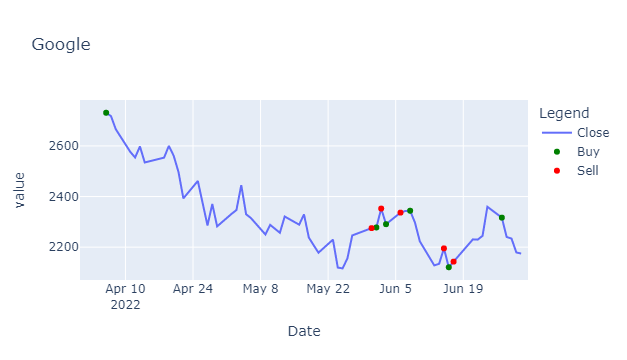

In [56]:
det['Buy'] = det[['Close','prd']].apply(lambda x: x.Close if x.prd == 'up' else 0,axis =1)
det['Sell'] = det[['Close','prd']].apply(lambda x: x.Close if x.prd == 'down' else 0,axis =1)
buySignal = det[det.Buy > 0][['Date','Buy']]
sellSignal = det[det.Sell > 0][['Date','Sell']]

# After we process the prediction, now we can use the time_series_transformer to generate
# the plot
det_tst = Time_Series_Transformer.from_pandas(det,'Date',None)
det_tst.plot(["Close"],'Google').add_marker(
    x = buySignal['Date'],
    y = buySignal['Buy'],color = 'green',
    legendName = 'Buy').add_marker(
    x = sellSignal['Date'],
    y = sellSignal['Sell'],color = 'red',
    legendName = 'Sell')